In [290]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
MM_HR_TO_MM_DAY = 24.0
MM_HR_TO_MM_YR = 24*365
FLUX_TO_MM_YR = FLUX_TO_MM_HR*MM_HR_TO_MM_YR
FLUX_TO_MM_DAY = FLUX_TO_MM_HR*MM_HR_TO_MM_DAY

HOURS_TO_RADIANS = 2*np.pi/24


In [291]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'
save_figs_dir_paper = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/paper_new/'
save_figs_dir_update = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_9_24/'
# save_fig_dir_update = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/for_me/'
##### open cmip5
# input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm5  = rel_data_dir + 'diurnal_analysis_results/CMIP5_bin_pt2_hr_round_regridded/grid1/'

#### open cmip6
# input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_round_regridded/grid1/' #GFDL-ESM4/'
# input_data_dir_cm6 = rel_data_dir + 'diurnal_analysis_results/CMIP6_clt_regridded/grid1/'

# input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results//GPM_bin_pt2_hr_15_yr_regridded/grid1/GPM_bin_pt2_hr_15_yr/'
# input_data_dir_gpm = rel_data_dir + 'diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round_regridded/grid1/GPM_bin_pt2_hr_15_yr_round/'
input_data_dir_gpm = rel_data_dir + 'diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round_final_regridded/grid1/GPM_bin_pt2_hr_15_yr_round_final/'
input_data_dir_gpm_mean_path = rel_data_dir + '/gpm_data/averages/10yr_regridded/grid1/10_yr/grid1_average_10yr.nc'


land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'

input_data_dir_mean_precip_3hr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_3hr_regridded/grid1/'
# paths to mean climate fields 



input_data_dir_rlut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/'
input_data_dir_rsut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/' 
input_data_dir_pr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/'
input_data_dir_clt = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/' 
input_data_dir_cltl = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/cltl_regridded/grid1/' 
input_data_dir_clth = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clth_regridded/grid1/' 
mean_fields_to_rel_path_map = {
    'rlut': input_data_dir_rlut,
    'rsut': input_data_dir_rsut,
    'pr': input_data_dir_pr,
    'clt':input_data_dir_clt,
    'cltl': input_data_dir_cltl,
    'clth': input_data_dir_clth,
}



In [292]:
input_data_dir_mean_precip_3hr

'/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_3hr_regridded/grid1/'

In [293]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [294]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




## Take mean accross seasons for GPM (circular for phase!)

In [76]:
# ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

# ### compute means
# # # take mean across seasons using circular mean for phase
# ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
# #                                    kwargs = {'low' : 0.0, 'high' : 24.0},
#                                    input_core_dims=[["season"]], 
#                                    vectorize = True)
# # compute yearly mean other data 
# ds_gpm = ds_gpm.mean(dim = 'season')
# ds_gpm['phase_season'] = ds_gpm_phase_year_mean

# #########

# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
# df_gpm = ds_gpm.to_dataframe()

# df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
# df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [125]:
# ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

# ### compute means
# # # take mean across seasons using circular mean for phase
# ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
# #                                    kwargs = {'low' : 0.0, 'high' : 24.0},
#                                    input_core_dims=[["season"]], 
#                                    vectorize = True)
# # compute yearly mean other data 
# ds_gpm = ds_gpm.mean(dim = 'season')
# ds_gpm['phase_season'] = ds_gpm_phase_year_mean

# ds_gpm['ampl_season'] = ds_gpm['ampl_season']*MM_HR_TO_MM_DAY
# ds_gpm['mu_season'] = ds_gpm['mu_season']*MM_HR_TO_MM_DAY


# #########

# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
# df_gpm = ds_gpm.to_dataframe()

In [15]:
df_gpm['mu_season'].values.dtype

dtype('float64')

In [295]:
%run model_by_model_analysis_helper.py

# open dataset containing gpm means 
df_gpm_mean = xr.open_dataset(input_data_dir_gpm_mean_path).to_dataframe()
df_gpm_mean = df_gpm_mean.rename({'precipitationCal': 'pr_mean'}, axis = 1)

# open an preprocess gpm
df_gpm_seasonal = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, False)
df_gpm = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, True)

# get amplitude/mean in mm/hr
df_gpm.loc[:,'ampl_season'] = df_gpm['ampl_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)
df_gpm.loc[:,'mu_season'] = df_gpm['mu_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)

# merge in mean field
df_gpm = pd.merge(df_gpm, df_gpm_mean, how = 'left', left_index = True, right_index = True)
ds_gpm = xr.Dataset.from_dataframe(df_gpm)

df_gpm_seasonal.loc[:,'ampl_season'] = df_gpm_seasonal['ampl_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)
df_gpm_seasonal.loc[:,'mu_season'] = df_gpm_seasonal['mu_season'].apply(lambda x: x*MM_HR_TO_MM_DAY)


# Load CMIP 5,6 models as a DataFrame

In [296]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = True,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 7min 27s, sys: 6.61 s, total: 7min 33s
Wall time: 7min 44s


In [28]:
# df

In [297]:
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = False,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = False,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,).reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df_seasonal = pd.merge(df_models, 
                       df_land_sea, 
                       how = 'left', 
                       left_index = True, 
                       right_index = True)
# df_seasonal = df_seasonal.reset_index('season')
df_seasonal = df_seasonal.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

In [80]:
# plt.savefig(‘test.pdf’, bbox_inches=‘tight’)

# Merge mean precip field into dataframe

In [298]:
%run model_by_model_analysis_helper.py
mean_precip_df = _load_all_means(input_data_dir_mean_precip_3hr)
mean_precip_merged = pd.merge(df.reset_index(), 
                              mean_precip_df.reset_index(), 
                              how = 'left', 
                              on = ['lat','lon','model_name'])
mean_precip_merged = mean_precip_merged.set_index(['lat','lon'])

df = mean_precip_merged.copy()


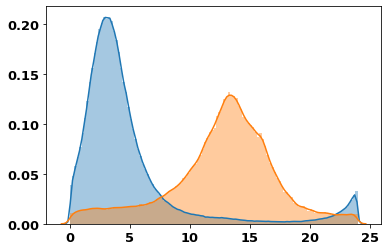

In [9]:
cmip_identifier = 'CMIP6'
field_id = 'phase_season'
nbins = 120
ax = None

df_water = df[(df['land_sea_mask'] == 0) & (df['cmip_identifier'] == cmip_identifier)] #[field_id]
df_land = df[(df['land_sea_mask'] == 1) & (df['cmip_identifier'] == cmip_identifier)] #[field_id]



sns.distplot(df_water[field_id].values , label = cmip_identifier + ' ' + 'Water', bins = nbins, ax = ax)
sns.distplot(df_land[field_id].values , label = cmip_identifier + ' ' + 'Land', bins = nbins, ax = ax)



In [ ]:
for model_name in df_water['model_name'].unique():
    sns.distplot(df_water[df_water['model_name'] == model_name][field_id].values , 
                 bins = nbins, 
                 ax = ax)



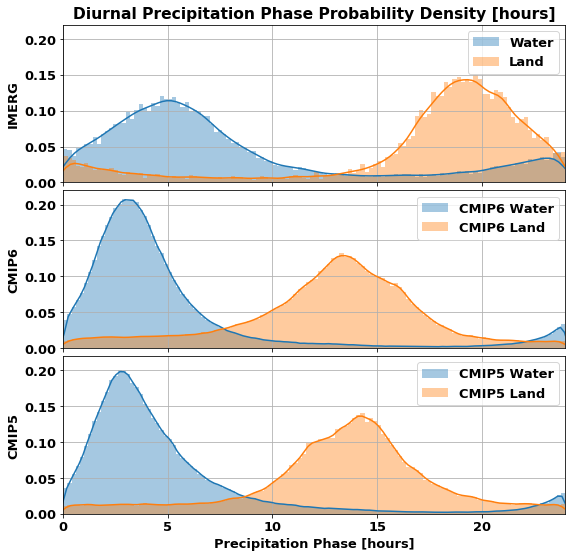

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [245]:
%run model_by_model_analysis_helper.py

fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))

land_sea_histogram(df_gpm, 
                   ax = ax_hist[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG')

land_sea_histogram(df,
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist[1],
                   ylabel = 'CMIP6')

land_sea_histogram(df,
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist[2],
                   ylabel = 'CMIP5',
                   xlabel = 'Precipitation Phase [Hour]')

fig.subplots_adjust(hspace=.05)

fig.savefig(save_figs_dir_paper + 'yearly_histogram.png', dpi = 300)



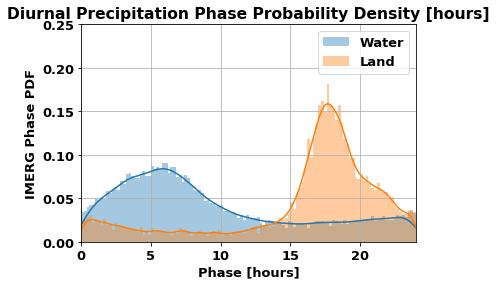

In [261]:
land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

In [34]:
# land_sea_histogram(filter_by_season(df, 'JJA'), nbins = 50)
# land_sea_histogram(df_gpm, field_id = 'ampl_season', nbins = 30)



# fig, ax_hist_season = plt.subplots(3, 1, sharex = True, figsize = (9,11))

# season_ii = 'JJA'

# land_sea_histogram(filter_by_season(df_gpm_seasonal, season_ii), 
#                    ax = ax_hist_season[0],
#                    title = 'Diurnal Precipitation Phase Probability Density [hours]',
#                    ylabel = 'IMERG Phase PDF')

# land_sea_histogram(filter_by_season(df_seasonal, season_ii),
#                    cmip_identifier= 'CMIP6',
#                    ax = ax_hist_season[1],
#                    ylabel = 'CMIP6 Probability Density')

# land_sea_histogram(filter_by_season(df_seasonal, season_ii),
#                    cmip_identifier = 'CMIP5',
#                    ax = ax_hist_season[2],
#                    ylabel = 'CMIP5 Probability Density',
#                    xlabel = 'Phase [Hour]')

# fig.subplots_adjust(hspace=.05)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

# compute error statistics


In [127]:
df_cmip6 = df[df['cmip_identifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_identifier'] == 'CMIP5']

# df_cmip6_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP6']
# df_cmip5_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP5']


field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_DAY*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_DAY*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

df_for_stats_cmip5, df_for_stats_cmip6 = df_cmip5.copy(), df_cmip6.copy()
df_for_stats_cmip5['ampl_season'] = FLUX_TO_MM_DAY*df_for_stats_cmip5['ampl_season']
df_for_stats_cmip6['ampl_season'] = FLUX_TO_MM_DAY*df_for_stats_cmip6['ampl_season']

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [162]:
# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# # compute precip weights
# df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# # merge gpm precip weights into model df 
# df_for_stats = pd.merge(df_for_stats, 
#                         df_for_stats_true['precip_weights'], 
#                         how = 'left', 
#                         left_index = True, 
#                         right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
# df_lat_lon_mode_ampl = df_for_stats.round(4).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
# df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
# cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
# cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)



# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

df_lat_lon_mean_cmip5 = df_for_stats_cmip5.groupby(['lat','lon']).mean()
cmip5_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip5)


df_lat_lon_mean_cmip6 = df_for_stats_cmip6.groupby(['lat','lon']).mean()
cmip6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip6)


df_lat_lon_err_cm6 = circdiff(df_lat_lon_mean_cmip6, df_for_stats_true)
cmip6_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err_cm6)
# cmips6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)

df_lat_lon_err_cm5 = circdiff(df_lat_lon_mean_cmip5, df_for_stats_true)
cmip5_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err_cm5)
# cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)




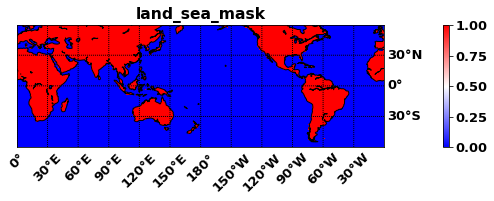

In [28]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))



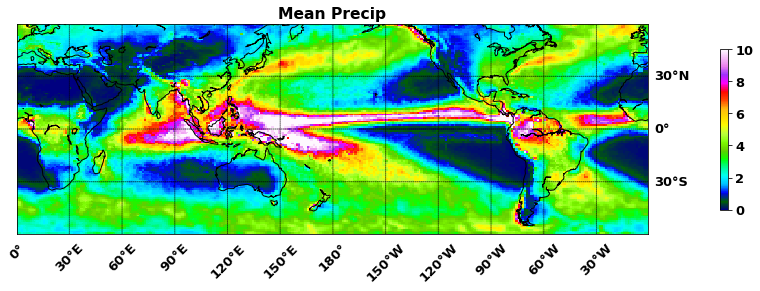

In [187]:
## Plot satellite data
%run diurnal_utils.py


make_single_plot(ds_gpm['pr_mean']*MM_HR_TO_MM_DAY ,
                 title = 'Mean Precip',
                 vmin = 0, vmax = 10, 
                 cmap  =plt.get_cmap('gist_ncar'))

In [ ]:
make_single_plot(ds_gpm['pr_mean']*MM_HR_TO_MM_DAY ,
                 title = 'Mean Precip',
                 vmin = 0, vmax = 10, 
                 cmap  =plt.get_cmap('gist_ncar'))

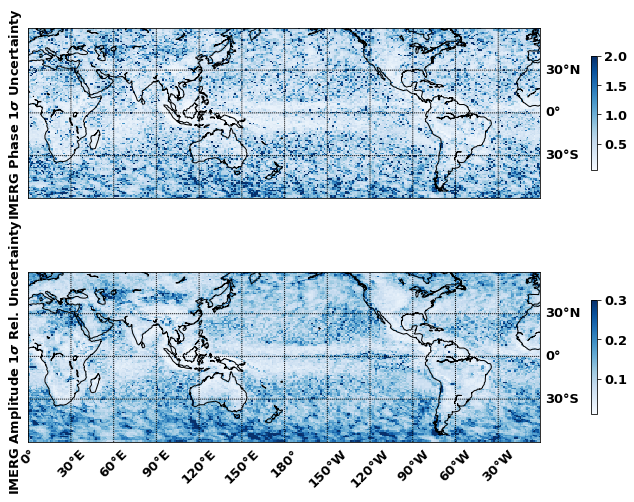

In [208]:
# cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season']

# make_single_plot(ds_gpm['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'] ,
#                  title = 'Mean Precip',
#                  vmin = 0, vmax = 10, 
#                  cmap  =plt.get_cmap('gist_ncar'))

# make_single_plot(ds_gpm['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'] ,
#                  title = 'Mean Precip',
#                  vmin = 0, vmax = 10, 
#                  cmap  =plt.get_cmap('gist_ncar'))


fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,7))

make_single_plot(ds_gpm['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'], 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 xticks_bool = False,
                 ylabel = r'IMERG Phase $1 \sigma$ Uncertainty ',
                 cmap = plt.get_cmap('Blues'), vmax = 2)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
ampl_rel_uncer = (MM_HR_TO_MM_DAY*ds_gpm['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'])/ds_gpm['ampl_season']
make_single_plot(ampl_rel_uncer,
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 vmax = 0.3,
                 ylabel = r'IMERG Amplitude $1 \sigma$ Rel. Uncertainty',
                cmap = plt.get_cmap('Blues'))
fig.subplots_adjust(hspace=.001)
fig.tight_layout()

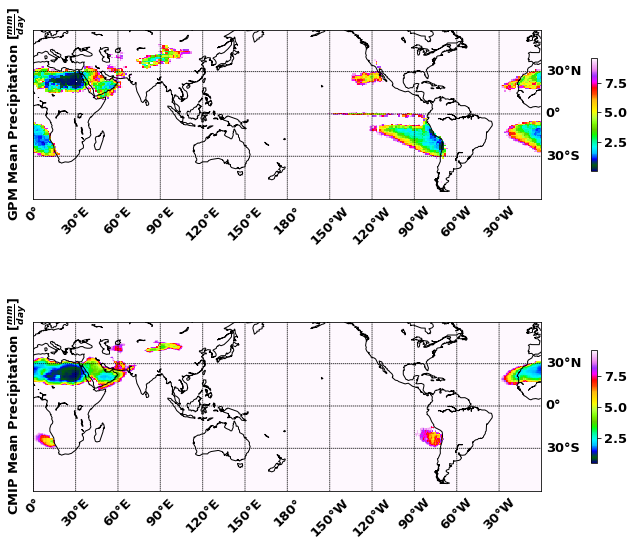

In [167]:


fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))


# make_single_plot(ds_gpm['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase [hours]',
#                  ax = ax_hist[0],
#                  fig = fig,
#                  ylabel = 'IMERG', 
#                  xticks_bool = False,
#                  cmap = plt.get_cmap('twilight_shifted'),
#                  vmin = 0, vmax = 24)





make_single_plot(ds_gpm['mu_season']*24, 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 ylabel = r'GPM Mean Precipitation [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
make_single_plot(cmips_mean_ds['mu_season'] *24, 
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CMIP Mean Precipitation [$\frac{mm}{day}$]',
                cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'mu_mean_spatial.png', dpi = 300)

# make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
#                  title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
#                   cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

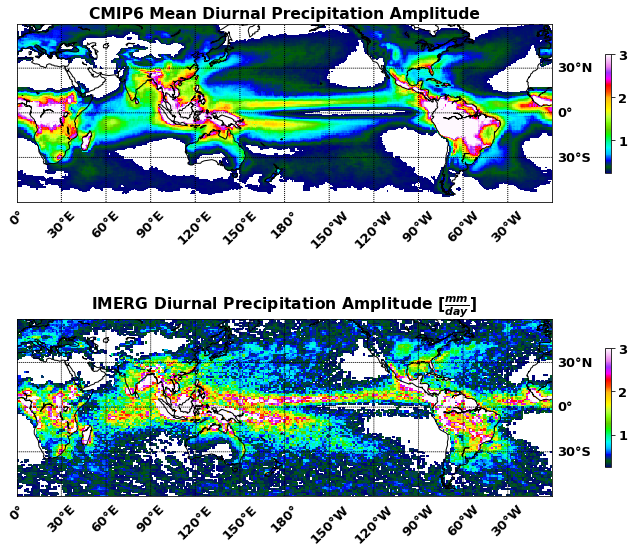

In [416]:
fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))

filter_ampl = 0.25
make_single_plot((cmips_mean_ds['ampl_season']*MM_HR_TO_MM_DAY).where((cmips_mean_ds['ampl_season']*MM_HR_TO_MM_DAY)> filter_ampl), 
                 fig = fig,
                 ax = ax_hist[0],
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 3)

make_single_plot((ds_gpm['ampl_season']*MM_HR_TO_MM_DAY).where((ds_gpm['ampl_season']*MM_HR_TO_MM_DAY)> filter_ampl),
                 fig = fig,
                 ax = ax_hist[1],
                 title = r'IMERG Diurnal Precipitation Amplitude [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 3)


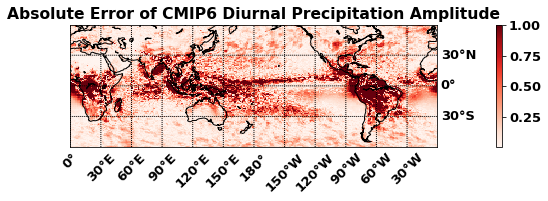

In [45]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Amplitude',
                 cmap = plt.get_cmap('Reds'), vmax = 1)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

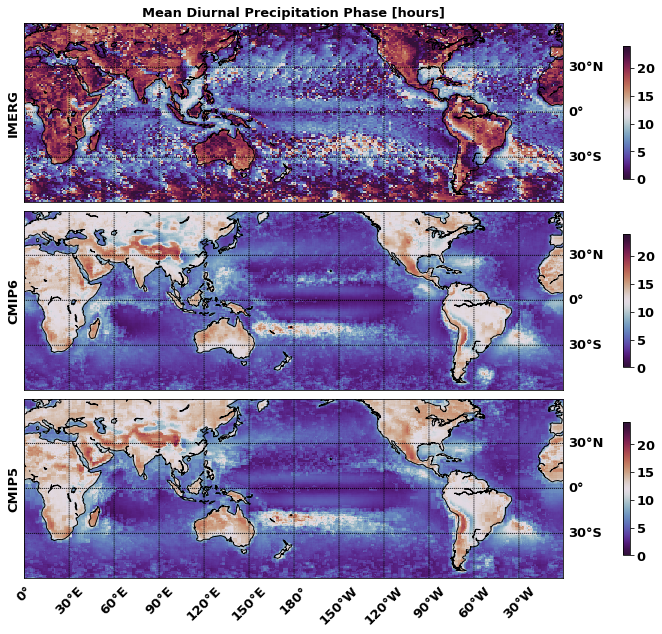

In [282]:
%run diurnal_utils.py


fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (10,9))


make_single_plot(ds_gpm['phase_season'], 
                 title = r'Mean Diurnal Precipitation Phase [hours]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip6_mean_ds['phase_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)




fig.subplots_adjust(hspace=.05)
# fig.savefig(save_figs_dir_paper + 'phase_mean_spatial_yearly.png', dpi = 300)



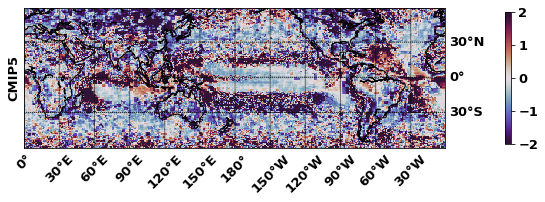

In [161]:
make_single_plot(cmip6_mean_ds['phase_season'] - cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
#                  ax = ax_hist[2],
#                  fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = -2, vmax = 2)

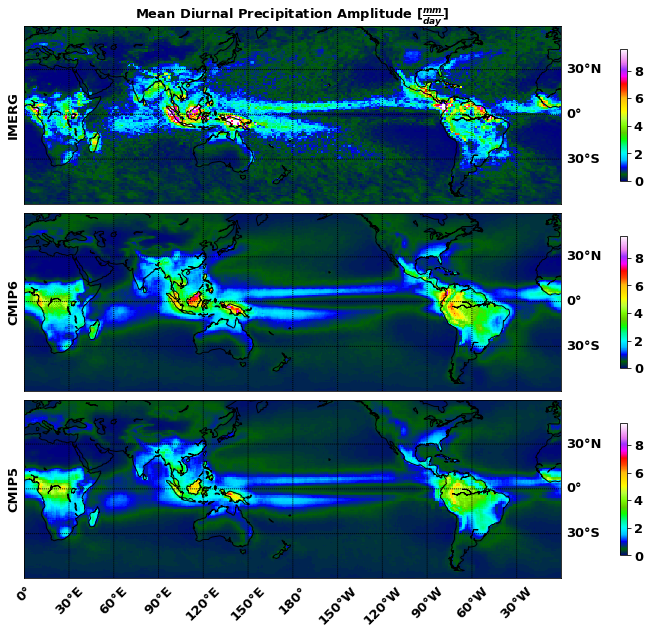

In [281]:
%run diurnal_utils.py
fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (10,9))


make_single_plot(ds_gpm['ampl_season'], 
                 title = r'Mean Diurnal Precipitation Amplitude [$\frac{mm}{day}$]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_DAY)

make_single_plot(cmip6_mean_ds['ampl_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_DAY)

make_single_plot(cmip5_mean_ds['ampl_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_DAY)

fig.subplots_adjust(hspace=.05)

# fig.savefig(save_figs_dir_paper + 'ampl_mean_spatial_yearly.png', dpi = 300)

In [315]:
# cmips_mean_ds
cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    phase_cov_season  (lat, lon) float64 0.2672 0.2721 0.2633 ... 0.355 0.3265

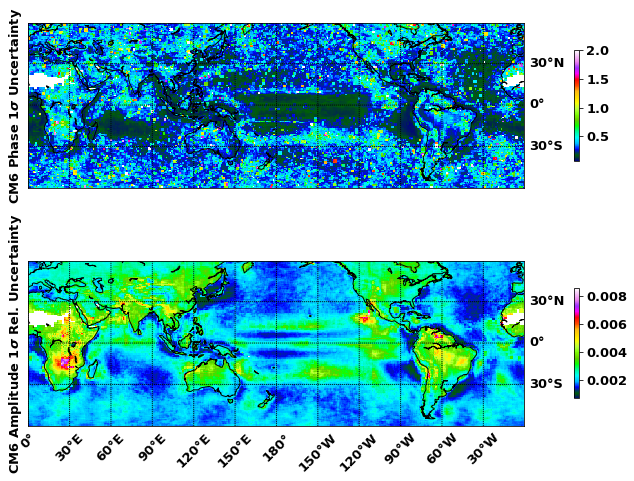

In [171]:
fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,7))

make_single_plot(cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'], 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 xticks_bool = False,
                 ylabel = r'CM6 Phase $1 \sigma$ Uncertainty ',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 2)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
ampl_rel_uncer = (FLUX_TO_MM_HR*cmips_mean_ds['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'])/cmips_mean_ds['ampl_season']
make_single_plot(ampl_rel_uncer,
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CM6 Amplitude $1 \sigma$ Rel. Uncertainty',
                cmap = plt.get_cmap('gist_ncar'))
fig.subplots_adjust(hspace=.001)
fig.tight_layout()
# plt.savefig(save_fig_dir_update + 'fit_error.png', dpi = 300)

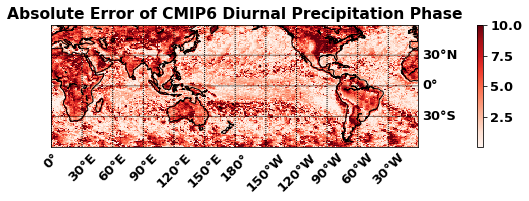

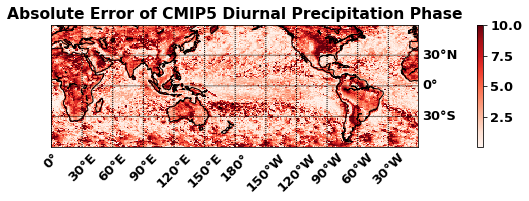

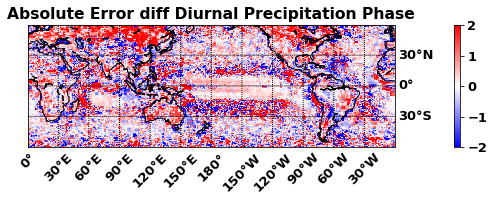

In [171]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))

make_single_plot(cmip6_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 10)

make_single_plot(cmip5_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP5 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 10)


make_single_plot(cmip6_err_ds['phase_season'] - cmip5_err_ds['phase_season'], 
                 title = r'Absolute Error diff Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('bwr'), vmin = -2, vmax = 2)


# Taylor Plots

In [95]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

# # calculate obs ampl
# obs_water_std = hour_circstd(obs_water_df['phase_season'])
# obs_land_std = hour_circstd(obs_land_df['phase_season'])


In [249]:
# input_data_dir_rlut
# mean_fields_to_rel_path_map

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/'}

In [ ]:
# os.listdir(input_data_dir_rlut)
%run model_by_model_analysis_helper.py

In [713]:


%run model_by_model_analysis_helper.py

# tropics
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_by_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat})


# # tropics water
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt', 'cltl', 'clth'],
#                       mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})
# subtropics
# min_lat, max_lat = 30, 60
min_lat, max_lat = -60, 60

# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': True})


# rr = _get_mean_field(field_name = 'pr',
#                       data_dir = mean_fields_to_rel_path_map['pr'],
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       var_mask_df = pr_mask_dict,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})




# stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
#      'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
#      'pr_dict': pr_dict, 'clt_dict': clt_dict}

In [703]:
# rr

In [283]:
%run model_by_model_analysis_helper.py




In [113]:
cmip_sens = cmip6_sensitivities.reset_index().rename({'index':'model_name'}, axis = 1)
cmip_means = field_means_df.reset_index().rename({'index':'model_name'}, axis = 1)
# merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_sens,
#                     how = 'left',
#                     on = 'model_name')
merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_means,
                    how = 'left',
                    on = 'model_name')

In [253]:
# corr_map_df
# field_means_df


In [238]:
%%time
corr_map_df = pd.DataFrame()
for lat_ii in merged_df['lat'].unique():
    print(lat_ii)
    for lon_ii in merged_df['lon'].unique():
        grid_cell_df = merged_df[(merged_df['lat'] == lat_ii) & (merged_df['lon'] == lon_ii)]
        out_df_row = grid_cell_df.corr()['clt']
        out_df_row['lat'] = lat_ii
        out_df_row['lon'] = lon_ii
        
        corr_map_df = corr_map_df.append(out_df_row)
# res = merged_df[['lat','lon','phase_season', 'ecs', 'tcr']].groupby(['lat','lon']).corr()


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


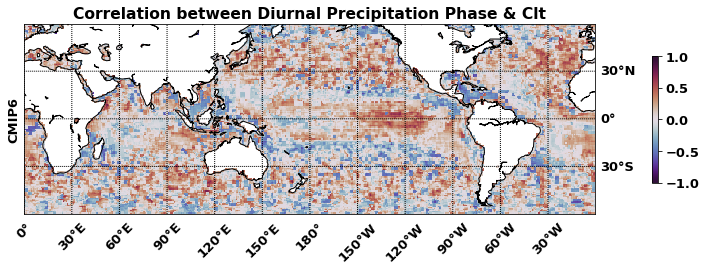

In [120]:
# corr_map_ds['phase_season'].plot.imshow()
corr_map_ds = xr.Dataset.from_dataframe(corr_map_df)
fig = plt.figure(figsize = (10,8))
make_single_plot(corr_map_ds['phase_season'], 
                 title = r'Correlation between Diurnal Precipitation Phase & Clt',
                 ax = plt.gca(),
                 fig = fig,
                 ylabel = 'CMIP6', 
                 xticks_bool = True,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = -1, vmax = 1)
# plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'phase_corr_clt_map.png', dpi = 300)

In [132]:
# corr_map_ds['phase_season'].where(ds_gpm['mu_season'] < 50).plot.imshow()


In [398]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
# model_error_stats_df= compute_stats(df_for_stats,
#                  df_for_stats_true,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  error_stats = True,
#                  additional_stats = True,)                

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  additional_stats = True,)


# ### compute stats for land/water
# model_error_stats_df_water = compute_stats(df_for_stats_water,
#                  df_for_stats_true_water,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True,)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
# min_lat, max_lat = -60, 60
# # # # min_lat, max_lat = 30, 60
# # # # min_lat, max_lat = 0, 60

# # # # min_lat, max_lat = 30, 60
# absolute_values = False

# # # print(min_lat, max_lat)
# # df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=False)
# # df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=False)


# df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=absolute_values)


# df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=absolute_values)



# # model_error_stats_df = compute_stats(df_for_stats_filt,
# #                  df_for_stats_true_filt,
# #                  agg_method = 'mean',
# #                  field = 'phase_season',
# #                  additional_stats = True, 
# #                  **stats_kwargs)
                

    
    

# model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
#                  df_for_stats_true_filt_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

# model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
#                  df_for_stats_true_filt_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

In [66]:
# # tropics water
%run model_by_model_analysis_helper.py

min_lat, max_lat = -60, 60

pr_mask_dict = {'data_dir': mean_fields_to_rel_path_map['pr'],
               'field_to_mask': 'pr',
               'field_threshold' : 0.5,
               'operator': 'lt',
               'unit_conversion': FLUX_TO_MM_DAY}

var_mask_df = _create_mask_for_all_models(
                model_list = os.listdir(mean_fields_to_rel_path_map['pr']),
                **pr_mask_dict)

# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt', 'clth','cltl'],
#                       mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
# #                       var_mask_df = pr_mask_dict,
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})

## Filter based on 3hr preciptiation means

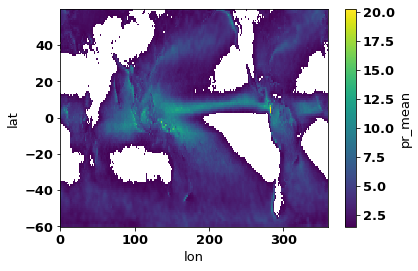

In [93]:
pr_mean_gpm_ds = df_gpm['pr_mean'].apply(lambda x: x*MM_HR_TO_MM_DAY)
pr_mean_gpm_ds = xr.Dataset.from_dataframe(pd.DataFrame(pr_mean_gpm_ds))

pr_mean_gpm_ds['pr_mean'].where(pr_mean_gpm_ds['pr_mean'] > 1.5).plot.imshow()

In [80]:
var_mask_df = df_cmip6[['model_name','pr_mean']].copy()
var_mask_df.loc[:,'pr_mean'] = var_mask_df['pr_mean'].apply(lambda x: x*FLUX_TO_MM_DAY)

## Filter based on monthly-mean precip data

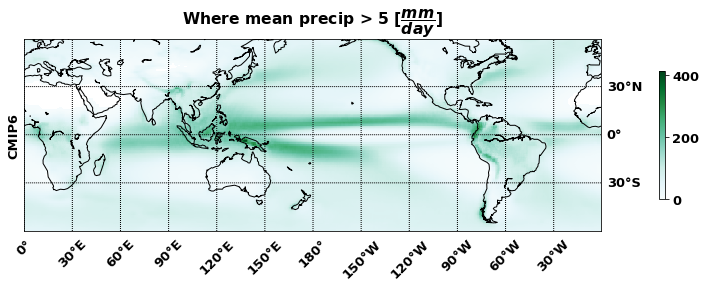

In [65]:
# field_means_df
fig = plt.figure(figsize = (10,8))
precip_where = (cmips_mean_ds['mu_season']*24).where(cmips_mean_ds['mu_season']*24 > 5)
make_single_plot(precip_where, 
#                  title = r'Correlation between Diurnal Precipitation Phase & Clt',
                 title = 'Where mean precip > 5 [$\dfrac{mm}{day}$]',
                 ax = plt.gca(),
                 fig = fig,
                 ylabel = 'CMIP6', 
                 xticks_bool = True,
                 cmap = plt.get_cmap('BuGn'),
                 vmin = 0,)
# plt.savefig(save_fig_dir_update + 'mean_precip_lt_5pt0_map.png', dpi = 300)

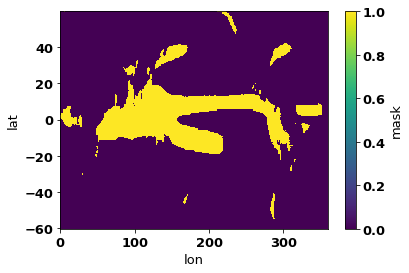

In [400]:
precip_mask = (precip_where > 0)
precip_mask.name = 'mask'
precip_mask_df = precip_mask.to_dataframe()
precip_mask.plot.imshow()

In [408]:
# precip_mask

In [268]:

### select season
# season_ii = 'DJF'
# df_for_analysis = model_error_stats_df_water
# df_for_analysis = df_for_analysis.reset_index('season')
# df_for_analysis = df_for_analysis[df_for_analysis['season'] == season_ii]


### yearly mean
df_for_analysis = model_error_stats_df_water

merge_sensitivities = pd.merge(df_for_analysis, cmip5_sensitivities, 
         how = 'left',
         left_index = True, 
         right_index = True)
all_stats_df = pd.merge(merge_sensitivities, field_means_df,
         how = 'left',
         left_index = True, 
         right_index = True)

NameError: name 'model_error_stats_df_water' is not defined

In [321]:
%%time
%run model_by_model_analysis_helper.py


# cmip6_stats_water, cmip6_stats_land = full_analysis(df_cmip6,
#                     df_gpm,
#                     cmip6_sensitivities,
#                     field_means_df, 
# #                     var_mask_df = var_mask_df,
#                     min_lat = -60, 
#                     max_lat = 60)

# analysis with error stats (CMIP6)
model_error_stats_df_water, model_error_stats_df_land = full_analysis(df_cmip6,
                    df_gpm,
                    cmip6_sensitivities,
#                     field_means_df, 
#                     var_mask_df = var_mask_df,
                    agg_method = 'mode',
                    error_stats = True,
                    min_lat = -60, 
                    max_lat = 60)

model_error_stats_df_water_mean, model_error_stats_df_land_mean = full_analysis(df_cmip6,
                    df_gpm,
                    cmip6_sensitivities,
#                     field_means_df, 
#                     var_mask_df = var_mask_df,
                    agg_method = 'mean',
                    error_stats = True,
                    min_lat = -60, 
                    max_lat = 60, 
                    absolute_value = False)


# # # analysis with error stats (CMIP5)
model_error_stats_df_water_cmip5, model_error_stats_df_land_cmip5 = full_analysis(df_cmip5,
                    df_gpm,
                    cmip5_sensitivities,
#                     field_means_df, 
#                     var_mask_df = var_mask_df,
                    agg_method = 'mode',
                    error_stats = True,
                    min_lat = -60, 
                    max_lat = 60)


model_error_stats_df_water_cmip5_mean, model_error_stats_df_land_cmip5_mean = full_analysis(df_cmip5,
                    df_gpm,
                    cmip5_sensitivities,
#                     field_means_df, 
#                     var_mask_df = var_mask_df,
                    agg_method = 'mean',
                    error_stats = True,
                    min_lat = -60, 
                    max_lat = 60,
                    absolute_value = False)
                                                                                


# cmip6_stats_water_summer, _ = full_analysis(df_cmip6_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip6_sensitivities,
# #                                             field_means_df,
#                                             agg_method = 'mode',
#                                             min_lat = 0,
#                                             max_lat = 60)
# cmip6_stats_water_summer = cmip6_stats_water_summer[cmip6_stats_water_summer['season'] == 'JJA']


# cmip5_stats_water, cmip5_stats_land = full_analysis(df_cmip5,
#                     df_gpm,
#                     cmip5_sensitivities)

# cmip5_stats_water_summer, _ = full_analysis(df_cmip5_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip5_sensitivities,
#                                             min_lat = 0,
#                                             max_lat = 60)

# cmip5_stats_water_summer = cmip5_stats_water_summer[cmip5_stats_water_summer['season'] == 'JJA']

CPU times: user 2min 21s, sys: 19.8 s, total: 2min 41s
Wall time: 1min 19s


In [304]:
model_error_stats_df_water_mean[['phase_mean', 'ecs']]

phase_mean  ecs
ACCESS-CM2          3.958235  4.7
ACCESS-ESM1-5       3.344022  3.9
AWI-CM-1-1-MR       3.028646  3.2
AWI-ESM-1-1-LR      3.036213  NaN
BCC-CSM2-MR         2.417040  3.0
CMCC-CM2-SR5        3.259951  NaN
CNRM-CM6-1          4.206957  4.8
CNRM-ESM2-1         4.266150  4.8
CanESM5             4.101475  5.6
EC-Earth3           3.410721  4.3
EC-Earth3-Veg       3.416565  4.3
EC-Earth3-Veg-LR    3.615215  NaN
FGOALS-g3           2.624703  NaN
GFDL-CM4            3.587782  3.9
GISS-E2-1-G         2.731516  2.7
IPSL-CM6A-LR        4.583781  4.6
KACE-1-0-G          3.973992  4.5
MIROC-ES2L          3.854015  2.7
MIROC6              3.067916  2.6
MPI-ESM-1-2-HAM     3.229329  NaN
MPI-ESM1-2-HR       2.986282  3.0
MPI-ESM1-2-LR       3.085292  3.0
MRI-ESM2-0          3.920490  3.2
NESM3               3.356148  4.7
SAM0-UNICON         4.851788  3.7
UKESM1-0-LL         3.785834  5.3

In [309]:
np.count_nonzero(~model_error_stats_df_water_cmip5_mean['ecs'].isnull())

17

In [288]:
rr = cmip6_stats_water_summer.groupby(['season', 'model_name']).apply(df_mean_lat_weighted, field_name = 'ampl_season')

In [242]:
# df_for_stats.groupby('model_name').apply(df_mean_lat_weighted, field_name = 'ampl_season')
df_for_stats_land[['ampl_season', 'phase_season', 'model_name']].groupby('model_name').apply(lat_weighted_circ_mean, field_name = 'phase_season')
#  df_for_stats.groupby('model_name').agg(np.mean)

model_name
ACCESS-CM2          13.094007
ACCESS-ESM1-5       12.739379
AWI-CM-1-1-MR       12.710616
AWI-ESM-1-1-LR      12.934233
BCC-CSM2-MR         10.599995
CMCC-CM2-SR5        15.039060
CNRM-CM6-1          10.952884
CNRM-ESM2-1         10.633973
CanESM5             12.741432
EC-Earth3           15.151427
EC-Earth3-Veg       15.152390
EC-Earth3-Veg-LR    15.370688
FGOALS-g3            1.463709
GFDL-CM4            10.627236
GISS-E2-1-G         13.514925
IPSL-CM6A-LR        15.101455
KACE-1-0-G          12.477539
MIROC-ES2L          13.233325
MIROC6              13.994836
MPI-ESM-1-2-HAM     13.186591
MPI-ESM1-2-HR       12.689663
MPI-ESM1-2-LR       12.892358
MRI-ESM2-0          14.429956
NESM3               12.626489
SAM0-UNICON         16.027264
UKESM1-0-LL         12.401806
dtype: float64

In [246]:
# df_for_stats_land[['phase_season', 'model_name']].groupby('model_name').apply(phase_circmean)



In [243]:
# df_mean_lat_weighted(df_for_stats[df_for_stats['model_name'] == 'IPSL-CM6A-LR'], 'ampl_season')
df_test = df_for_stats_land[df_for_stats_land['model_name'] == 'ACCESS-CM2']
lat_weighted_circ_mean(df_test, field_name = 'phase_season')

13.094007048160753

In [210]:
df_mean_lat_weighted(df_for_stats_land[df_for_stats_land['model_name'] == 'ACCESS-CM2'],'phase_season' )

12.418879341498402

In [211]:
phase_circmean(df_test['phase_season'].values)

12.747074961818495

In [222]:
rr = lat_weighted_circ_mean_test(df_test, field_name = 'phase_season')

In [176]:
# cmip6_stats_water_summer
# agg_field_by_model_ = cmip6_stats_water_summer.groupby(['season','model_name']).apply(df_mean_lat_weighted, field_name = 'ampl_season')
# agg_phase_by_model_ = cmip6_stats_water_summer.groupby(['season','model_name']).apply(lat_weighted_circ_mean, field_name = 'phase_season')

In [175]:
ff = agg_phase_by_model_.reset_index('season')
ff[ff['season'] == 'SON']

season          0
model_name                        
ACCESS-CM2          SON -11.266178
ACCESS-ESM1-5       SON -11.887728
AWI-CM-1-1-MR       SON -11.581094
AWI-ESM-1-1-LR      SON -11.316528
BCC-CSM2-MR         SON  10.535746
CMCC-CM2-SR5        SON  -8.947131
CNRM-CM6-1          SON  11.095685
CNRM-ESM2-1         SON  10.853294
CanESM5             SON -11.329597
EC-Earth3           SON  -9.404818
EC-Earth3-Veg       SON  -9.391384
EC-Earth3-Veg-LR    SON  -8.920507
FGOALS-g3           SON   2.020449
GFDL-CM4            SON  10.839053
GISS-E2-1-G         SON -11.510878
IPSL-CM6A-LR        SON  -8.842505
KACE-1-0-G          SON  11.995479
MIROC-ES2L          SON -10.692395
MIROC6              SON  -9.644139
MPI-ESM-1-2-HAM     SON -10.864681
MPI-ESM1-2-HR       SON -11.618149
MPI-ESM1-2-LR       SON -11.339888
MRI-ESM2-0          SON -10.042968
NESM3               SON -11.754175
SAM0-UNICON         SON  -7.912995
UKESM1-0-LL         SON -11.843640

In [241]:
%run model_by_model_analysis_helper.py


In [100]:
ff = agg_phase_by_model_.reset_index('season')
ff[ff['season'] == 'SON']

season          0
model_name                        
ACCESS-CM2          SON -11.266178
ACCESS-ESM1-5       SON -11.887728
AWI-CM-1-1-MR       SON -11.581094
AWI-ESM-1-1-LR      SON -11.316528
BCC-CSM2-MR         SON  10.535746
CMCC-CM2-SR5        SON  -8.947131
CNRM-CM6-1          SON  11.095685
CNRM-ESM2-1         SON  10.853294
CanESM5             SON -11.329597
EC-Earth3           SON  -9.404818
EC-Earth3-Veg       SON  -9.391384
EC-Earth3-Veg-LR    SON  -8.920507
FGOALS-g3           SON   2.020449
GFDL-CM4            SON  10.839053
GISS-E2-1-G         SON -11.510878
IPSL-CM6A-LR        SON  -8.842505
KACE-1-0-G          SON  11.995479
MIROC-ES2L          SON -10.692395
MIROC6              SON  -9.644139
MPI-ESM-1-2-HAM     SON -10.864681
MPI-ESM1-2-HR       SON -11.618149
MPI-ESM1-2-LR       SON -11.339888
MRI-ESM2-0          SON -10.042968
NESM3               SON -11.754175
SAM0-UNICON         SON  -7.912995
UKESM1-0-LL         SON -11.843640

In [75]:
test_df = cmip6_stats_water_summer[(cmip6_stats_water_summer['model_name'] == 'NESM3') & \
                                  (cmip6_stats_water_summer['season'] == 'SON')]

In [76]:
print(df_mean_lat_weighted(test_df, field_name = 'ampl_season'))
print(lat_weighted_circ_mean(test_df, field_name = 'phase_season'))

1.3891463538531525
-11.754175275682945


In [141]:
print(phase_circmean(test_df['phase_season'].values))
print(test_df['phase_season'].values.mean())

11.967977757494063
11.776677370504396


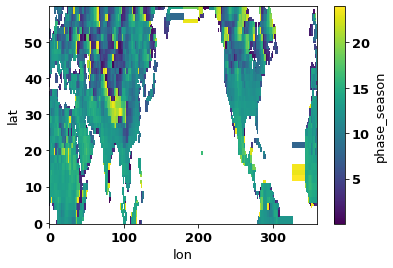

In [98]:
xr.Dataset.from_dataframe(test_df)['phase_season'].plot()

1.585505737910568

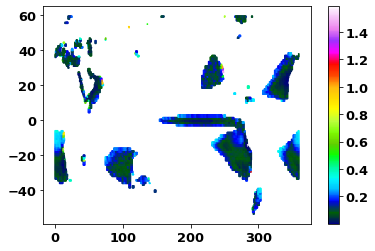

In [697]:
# fld = 'ampl_season'
# ds_sing = cmip6_stats_water[cmip6_stats_water['model_name'] == 'IPSL-CM6A-LR'].reset_index()
# plt.scatter( x= ds_sing['lon'].values, 
#             y = ds_sing['lat'].values, 
#             c = ds_sing[fld].values, s = 0.5,
#             cmap = plt.get_cmap('gist_ncar'))
# #             cmap = plt.get_cmap('twilight_r'))
# plt.colorbar()
# ds_sing.max()[fld]

In [490]:
# cmip6_stats_water_summer
mode(cmip6_stats_land['phase_mean'].values)


ModeResult(mode=array([12.8]), count=array([2]))

In [491]:
mode(cmip5_stats_land['phase_mean'].values)

ModeResult(mode=array([11.6]), count=array([2]))

In [492]:
mode(df_gpm_land['phase_season'].round(1).values)

ModeResult(mode=array([19.2]), count=array([828]))

In [123]:
# save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/corr_heatmaps/CMIP6/'
save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_9_10/' 

## Make Correlation Heatmap

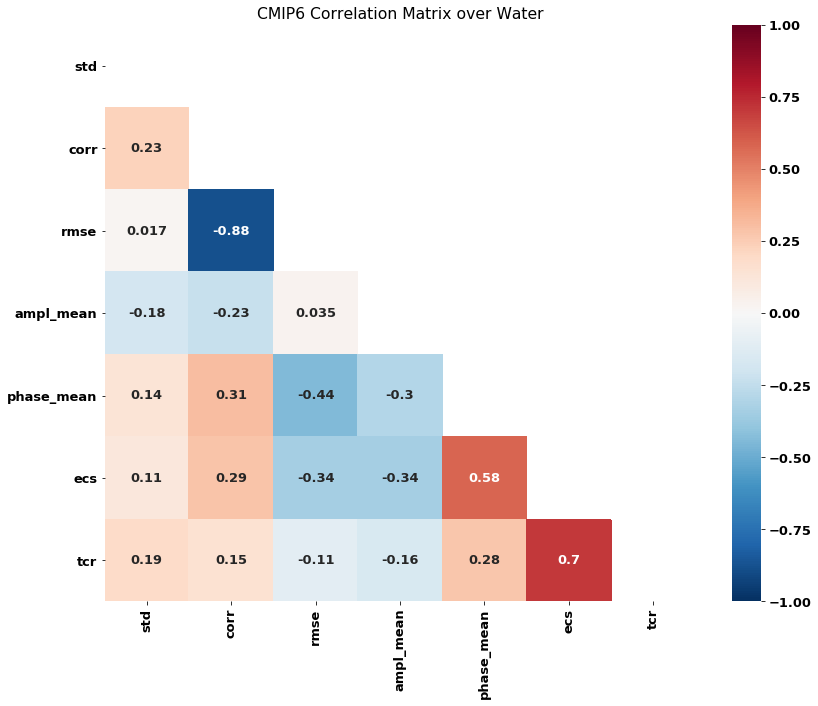

In [313]:
%run model_by_model_analysis_helper.py
# corr_mat_ds = cmip6_stats_water_summer[cmip6_stats_water_summer['season'] == 'JJA']
corr_mat_ds = model_error_stats_df_water_mean

plot_corr_matrix(corr_mat_ds, 
                 title = 'CMIP6 Correlation Matrix over Water')

# .drop('')
# plt.savefig(save_fig_dir_update + 'cmip6_corr_mat_water_precip_lt0pt5.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_max_cloud_cover.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_nh_all_djf.png', dpi = 300)

In [224]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = all_stats_df
# .drop(['IPSL-CM6A-LR']) #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

# mes_df_season = model_error_stats_df.reset_index('season')
# mes_df_season = mes_df_season[mes_df_season['season'] == 'JJA']

# corr_mat_ds = mes_df_season

# plt.figure(figsize = (12,10))
# plt.title('Correlation Matrix for All Latitudes [Method: mode]')
# upper_tr_mask = np.triu(corr_mat_ds.corr())
# sns.heatmap(corr_mat_ds.corr(), annot = True, 
#             vmin = -1, vmax = 1, center = 0, fmt='.2g',
#             mask = upper_tr_mask)

# plt.tight_layout()
plot_corr_matrix(corr_mat_ds)
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

NameError: name 'all_stats_df' is not defined

In [94]:
# model_error_stats_df
# model_error_stats_df.sort_values('rmse')

In [116]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',
                   xlabel = 'Phase Mean [Hours]',
                   ylabel = 'ECS',
                   obs_x = None,
                   figsize = (8,5),
                   annotate_bool = True):
    plt.figure(figsize = figsize)
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    if xlabel:
        plt.xlabel(xlabel, weight = 'bold')
        
    if ylabel:
        plt.ylabel(ylabel, weight = 'bold')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
    if annotate_bool:
        plt.annotate('Corr:' + '{:.3f}'.format(corr), 
                     xy=(0.75, 0.01), xycoords='axes fraction')
    if not (obs_x is None):
        plt.axvline(x=obs_x, color='r', linestyle='--')


    plt.tight_layout()

In [130]:

# metric_scatter(model_error_stats_df_land)
# plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(all_stats_df)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)

# metric_scatter(model_error_stats_df_land, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


# metric_scatter(model_error_stats_df_water, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



NameError: name 'all_stats_df' is not defined

In [210]:
# cmip6_stats_water
# corr_mat_ds
phase_observed_water_mean

5.334830363871928

0.5742301159132428


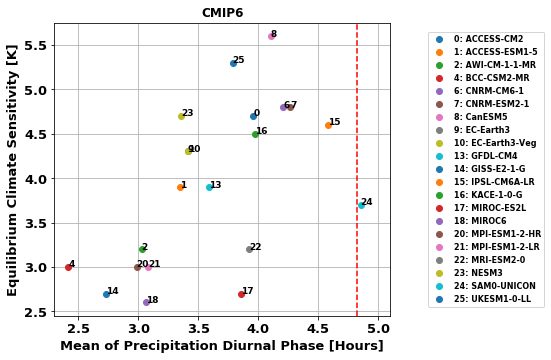

In [289]:
# plt.figure(figsize = (7,10))

metric_scatter(model_error_stats_df_water_mean,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               xlabel = 'Mean of Precipitation Diurnal Phase [Hours]',
               ylabel = 'Equilibrium Climate Sensitivity [K]',
               obs_x = phase_observed_water_mean, 
               figsize = (8,5), 
               annotate_bool=False)
plt.xlim([2.3, 5.1])
plt.title('CMIP6', weight = 'bold', fontsize = 12)
# save_fig_dir_update
# plt.savefig(save_figs_dir_update + 'ecs_vs_phase_water_precip_mode.png', dpi = 300)
plt.savefig(save_figs_dir_paper + 'ecs_vs_phase_water.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_phase_ecs_water.png', dpi = 250)





# metric_scatter(cmip6_stats_water, 
#                x_field = 'phase_mean',  
#                y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
#                ylabel = 'ECS [K]',
#                figsize = (8,5), 
#                annotate_bool=True)
# # plt.xticks(rotation=45)
# plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_new.png', dpi = 300)




In [261]:
# cmip6_stats_water

df_gpm_seasonal_subset = df_gpm_seasonal.reset_index(2)

df_gpm_seasonal_subset = df_gpm_seasonal_subset[df_gpm_seasonal_subset['land_sea_mask'] == 0]

df_gpm_seasonal_subset = df_gpm_seasonal_subset[df_gpm_seasonal_subset['season'] == 'JJA']


df_gpm_seasonal_subset = filter_by_lat(df_gpm_seasonal_subset, 0, 60)

In [275]:
# xr.Dataset.from_dataframe(df_gpm_seasonal_subset)['phase_season'].plot()
print(mode_apply(df_gpm_seasonal_subset['phase_season'].round(1)))
print(phase_circmean(df_gpm_seasonal_subset['phase_season']))

5.9
5.608771708489219


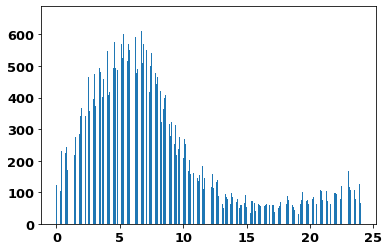

In [277]:
_ = plt.hist(df_gpm_seasonal_subset['phase_season'].round(1), bins = 500)



-0.018664103787040535


Text(0.5, 1, 'CMIP6')

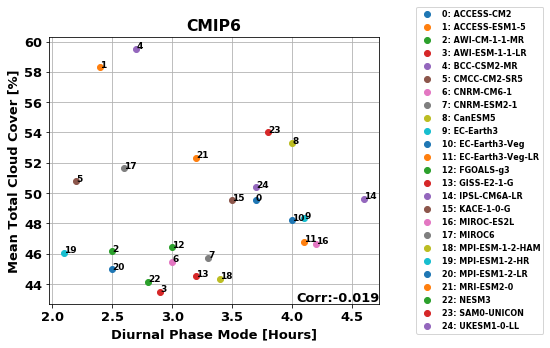

In [108]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

metric_scatter(cmip6_stats_water,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Diurnal Phase Mode [Hours]',
               figsize = (8,5), 
               ylabel = 'Mean Total Cloud Cover [%]',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_dir_update + 'clt_vs_phase_water_precip_gt_1pt5.png', dpi = 300)



In [204]:
# cmip6_stats_water


0.6759081083383556


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Amplitude')

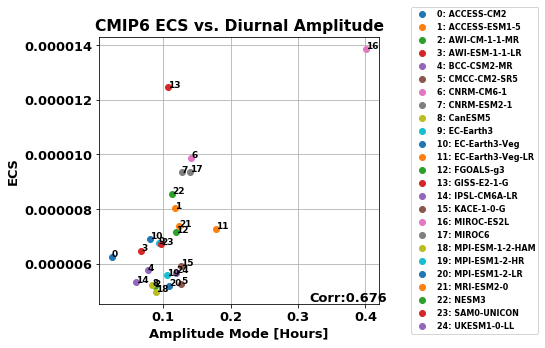

In [109]:
metric_scatter(cmip6_stats_water,  
               y_field = 'pr', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mode [Hours]')
plt.title('CMIP6 ECS vs. Diurnal Amplitude', weight = 'bold')

0.3392717025148377


Text(0.5, 1, 'CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude')

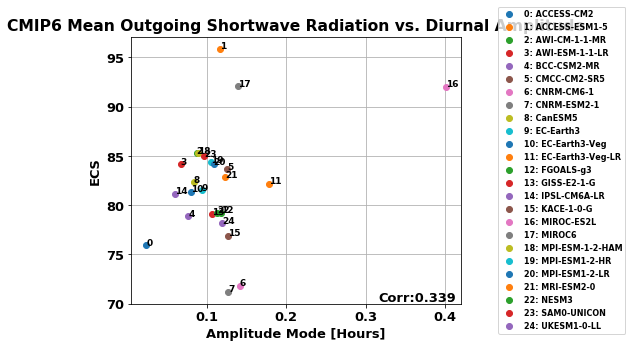

In [110]:
metric_scatter(cmip6_stats_water,  
               y_field = 'rsut', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mode [Hours]')
plt.title('CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




In [248]:
# metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
# plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.03795638004154456


Text(0.5, 1, 'CMIP6')

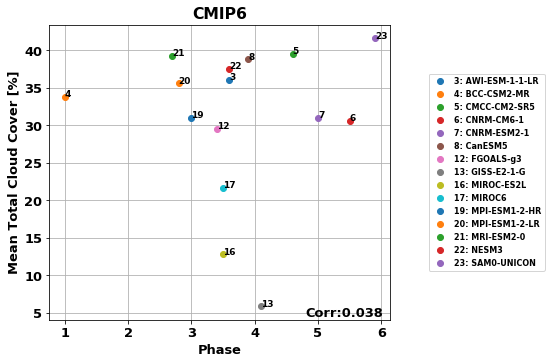

In [91]:
metric_scatter(cmip6_stats_water,  
               y_field = 'clth', 
               x_field = 'phase_mean',
               ylabel = 'Mean Total Cloud Cover [%]',
               xlabel = 'Phase',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_clt_ecs_water.png', dpi = 250)




# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [38]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

In [505]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_water.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_water.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_water.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. IMERG Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

NameError: name 'gpm_std' is not defined

<Figure size 936x576 with 0 Axes>

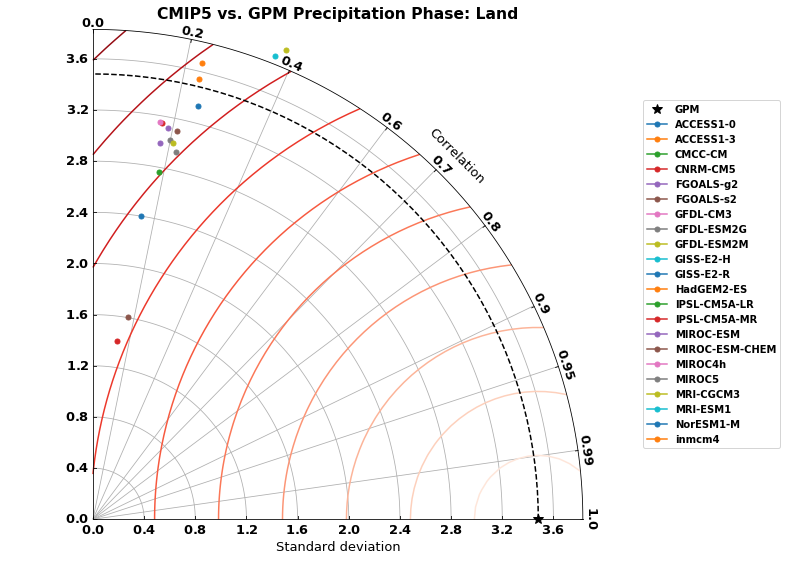

In [96]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

In [93]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
# _ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
#               density = True, cmap = plt.get_cmap('gist_ncar'))
# plt.xlim([0, 0.2])
# plt.colorbar()

In [350]:
# df_for_stats_land
summary_stats_for_df(df_for_stats_true_land, agg_method = 'mode')

(0.4424, 19.2)

0.3622


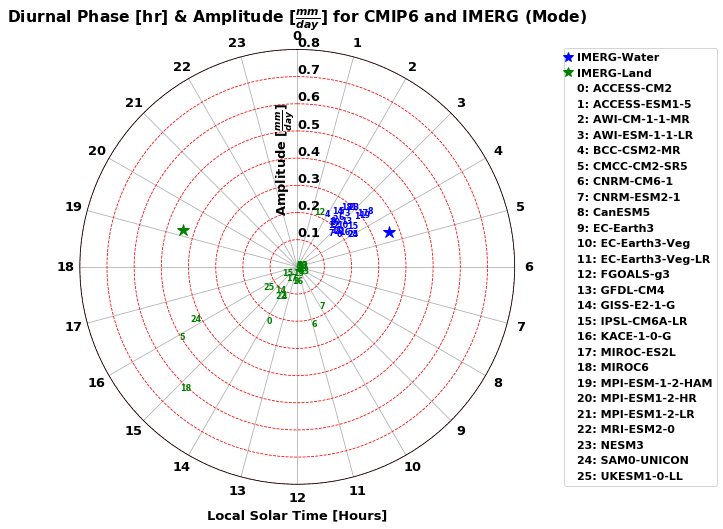

In [443]:
# import importlib
# # import PhaseDiagram
# # importlib.reload(phaseDiagram)

# # %run phaseDiagram.py
%run model_by_model_analysis_helper.py




make_phase_plot(model_error_stats_df_water,
                model_error_stats_df_land,
                df_for_stats_true_water,
                df_for_stats_true_land,
                 title = r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{day}$] for CMIP6 and IMERG (Mode)',
                agg_method = 'mode',
                y_lim = (0,0.8),
               )


plt.savefig(save_figs_dir_update + 'phase_plot_mode_cmip6.png', dpi = 300)

0.7110827131923169


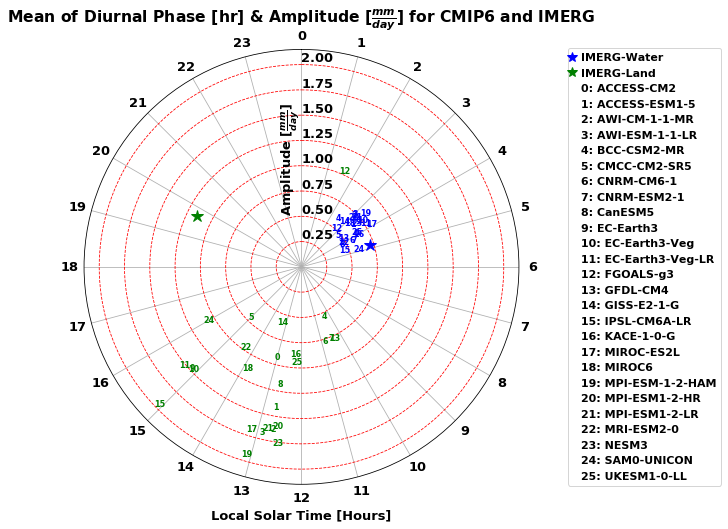

In [145]:
%run model_by_model_analysis_helper.py
make_phase_plot(model_error_stats_df_water_mean,
                model_error_stats_df_land_mean,
                df_for_stats_true_water,
                df_for_stats_true_land,
                title = r'Mean of Diurnal Phase [hr] & Amplitude [$\frac{mm}{day}$] for CMIP6 and IMERG',
                agg_method = 'mean',
                y_lim = (0, 2.15),
               )
# plt.savefig(save_figs_dir_paper + 'phase_plot_mean_cmip6.png', dpi = 300)
# plt.savefig(save_figs_dir_update + 'phase_plot_mean_cmip6.png', dpi = 300)


In [ ]:
mode_apply(df_for_stats_true_water['phase_season'].round(1))

In [141]:
%run model_by_model_analysis_helper.py




make_phase_plot(model_error_stats_df_water_cmip5,
                model_error_stats_df_land_cmip5,
                df_for_stats_true_water,
                df_for_stats_true_land,
                 title = r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{day}$] for CMIP5 and IMERG (Mode)',
                agg_method = 'mode',
                y_lim = (0,0.8),
               )


# plt.savefig(save_figs_dir_update + 'phase_plot_mode_cmip5.png', dpi = 300)

NameError: name 'model_error_stats_df_water_cmip5' is not defined

0.7110827131923169


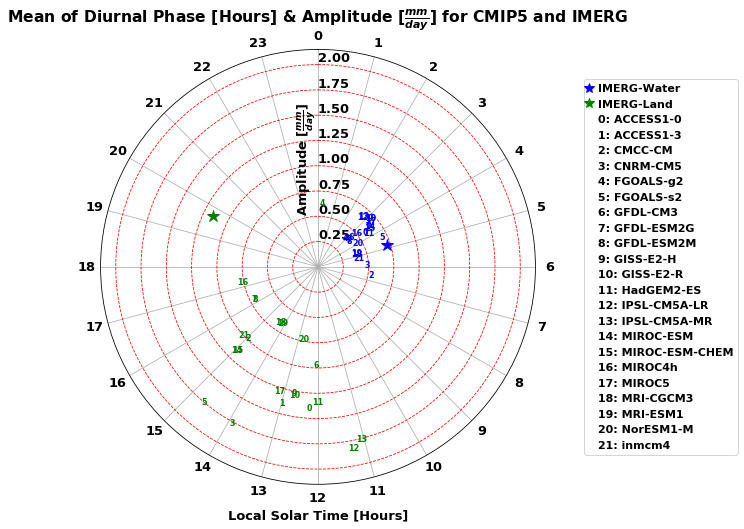

In [144]:
%run model_by_model_analysis_helper.py
make_phase_plot(model_error_stats_df_water_cmip5_mean,
                model_error_stats_df_land_cmip5_mean,
                df_for_stats_true_water,
                df_for_stats_true_land,
                title = r'Mean of Diurnal Phase [Hours] & Amplitude [$\frac{mm}{day}$] for CMIP5 and IMERG',
                agg_method = 'mean',
                y_lim = (0, 2.15),
               )
# plt.savefig(save_figs_dir_paper + 'phase_plot_mean_cmip5.png', dpi = 300)
# plt.savefig(save_figs_dir_update + 'phase_plot_mean_cmip5.png', dpi = 300)





# Summary Stats for models/obs

In [318]:
%run model_by_model_analysis_helper.py

# all lats
ampl_observed_water_mean, phase_observed_water_mean = summary_stats_for_df(df_for_stats_true_water, 
                                                                 agg_method = 'mean')

# # subset lat
# ampl_observed_water_mean, phase_observed_water_mean = summary_stats_for_df(
#                                                                 filter_by_lat(df_for_stats_true_water, 
#                                                                               -60, 
#                                                                               60,
#                                                                              absolute_value = False),
#                                                                  agg_method = 'mean')

ampl_observed_land_mean, phase_observed_land_mean = summary_stats_for_df(df_for_stats_true_land, 
                                                                agg_method = 'mean')

ampl_observed_water_mode, phase_observed_water_mode = summary_stats_for_df(df_for_stats_true_water, 
                                                                 agg_method = 'mode')
    
ampl_observed_land_mode, phase_observed_land_mode = summary_stats_for_df(df_for_stats_true_land, 
                                                                agg_method = 'mode')

In [148]:
# xr.Dataset.from_dataframe(df_for_stats_true_water)['phase_season'].plot.imshow(cmap = 
#                                                                              plt.get_cmap('twilight_shifted'),vmax = 24)

In [324]:
# take mean of spatial mean for cmip5
cm5_phase_mean_water = model_error_stats_df_water_cmip5_mean.mean()['phase_mean']
cm5_phase_mean_land = phase_circmean(model_error_stats_df_land_cmip5_mean['phase_mean'])
cm5_ampl_mean_water = model_error_stats_df_water_cmip5_mean.mean()['ampl_mean']
cm5_ampl_mean_land = phase_circmean(model_error_stats_df_land_cmip5_mean['ampl_mean'])

# take mean of spatial mode for cmip5
cm5_phase_mean_water_mode = model_error_stats_df_water_cmip5.mean()['phase_mean']
cm5_phase_mean_land_mode = phase_circmean(model_error_stats_df_land_cmip5['phase_mean'])
cm5_ampl_mean_water_mode = model_error_stats_df_water_cmip5.mean()['ampl_mean']
cm5_ampl_mean_land_mode = phase_circmean(model_error_stats_df_land_cmip5['ampl_mean'])


# take mean of spatial mean for cmip6
cm6_phase_mean_water = model_error_stats_df_water_mean.mean()['phase_mean']
cm6_phase_mean_land = phase_circmean(model_error_stats_df_land_mean['phase_mean'])
cm6_ampl_mean_water = model_error_stats_df_water_mean.mean()['ampl_mean']
cm6_ampl_mean_land = model_error_stats_df_land_mean['ampl_mean'].mean()


# take mean of spatial mode for cmip6
cm6_phase_mean_water_mode = model_error_stats_df_water.mean()['phase_mean']
cm6_phase_mean_land_mode = phase_circmean(model_error_stats_df_land['phase_mean'])
cm6_ampl_mean_water_mode = model_error_stats_df_water.mean()['ampl_mean']
cm6_ampl_mean_land_mode = model_error_stats_df_land['ampl_mean'].mean()

In [325]:
print('CMIP5 Phase Stats....')
print('Water mean: ', cm5_phase_mean_water - phase_observed_water_mean)
print('Water mode: ', cm5_phase_mean_water_mode - phase_observed_water_mode)

print('Land mean: ', cm5_phase_mean_land - phase_observed_land_mean)
print('Land mode: ', cm5_phase_mean_land_mode - phase_observed_land_mode)


print('CMIP6 Phase Stats....')
print('Water mean: ', cm6_phase_mean_water - phase_observed_water_mean)
print('Water mode: ', cm6_phase_mean_water_mode - phase_observed_water_mode)

print('Land mean: ', cm6_phase_mean_land - phase_observed_land_mean)
print('Land mode: ', cm6_phase_mean_land_mode - phase_observed_land_mode)

CMIP5 Phase Stats....
Water mean:  -1.0256119834924275
Water mode:  -1.9454545454545453
Land mean:  -5.7673685804882275
Land mode:  -4.911768955629924
CMIP6 Phase Stats....
Water mean:  -1.2954466766228219
Water mode:  -2.038461538461538
Land mean:  -6.5136213347615115
Land mode:  -4.792824361973482


In [236]:
print('CMIP5 Ampl Stats....')
print('Water mean: ', cm5_ampl_mean_water - ampl_observed_water_mean)
# print('Water mode: ', cm5_ampl_mean_water_mode - a mpl_observed_water_mode)

print('Land mean: ', cm5_ampl_mean_land - ampl_observed_land_mean)
# print('Land mode: ', cm5_ampl_mean_land_mode - ampl_observed_land_mode)


print('CMIP6 Ampl Stats....')
print('Water mean: ', cm6_ampl_mean_water - ampl_observed_water_mean)
# print('Water mode: ', cm6_ampl_mean_water_mode - ampl_observed_water_mode)

print('Land mean: ', cm6_ampl_mean_land - ampl_observed_land_mean)
# print('Land mode: ', cm6_ampl_mean_land_mode - ampl_observed_land_mode)

CMIP5 Ampl Stats....
Water mean:  -0.20497892023851205
Land mean:  0.02478335880871585
CMIP6 Ampl Stats....
Water mean:  -0.1199514550394446
Land mean:  0.10763965651190932


In [326]:
print('CMIP5------------------')
print(model_error_stats_df_water_cmip5_mean.mean())
print(model_error_stats_df_land_cmip5_mean.mean())
print('CMIP6------------------')
print(model_error_stats_df_water_mean.mean())
print(model_error_stats_df_land_mean.mean())

CMIP5------------------
std           2.683847
corr          0.178438
rmse          4.533752
ampl_mean     0.506104
phase_mean    3.796760
ecs           3.235294
tcr           1.738889
dtype: float64
std            3.339328
corr           0.227249
rmse           6.266507
ampl_mean      1.175703
phase_mean    13.240026
ecs            3.235294
tcr            1.738889
dtype: float64
CMIP6------------------
std           2.559501
corr          0.168788
rmse          4.453843
ampl_mean     0.591131
phase_mean    3.526925
ecs           3.928571
tcr           2.040000
dtype: float64
std            3.561131
corr           0.250097
rmse           6.479138
ampl_mean      1.258400
phase_mean    12.761048
ecs            3.928571
tcr            2.040000
dtype: float64


## Spatial Mean Statistics

In [232]:
cm6_std_phase_mean_water = circstd(model_error_stats_df_water_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm6_std_ampl_mean_water = model_error_stats_df_water_mean.std()['ampl_mean']
cm6_std_phase_mean_land = circstd(model_error_stats_df_land_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm6_std_ampl_mean_land = model_error_stats_df_land_mean.std()['ampl_mean']



cm5_std_phase_mean_water = circstd(model_error_stats_df_water_cmip5_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm5_std_ampl_mean_water = model_error_stats_df_water_cmip5_mean.std()['ampl_mean']
cm5_std_phase_mean_land = circstd(model_error_stats_df_land_cmip5_mean['phase_mean'].values, low = 0.0, high = 24.0)
cm5_std_ampl_mean_land = model_error_stats_df_land_cmip5_mean.std()['ampl_mean']


print("Summary")
print("Water")
print(cm5_std_phase_mean_water, cm5_std_ampl_mean_water)
print(cm6_std_phase_mean_water, cm6_std_ampl_mean_water)

print("Land")
print(cm5_std_phase_mean_land, cm5_std_ampl_mean_land)
print(cm6_std_phase_mean_land, cm6_std_ampl_mean_land)

Summary
Water
1.0745872225890156 0.11898857398316402
0.5903029855984238 0.10914390345281724
Land
2.314490223431394 0.3942779652307035
2.177240879168321 0.438814613196659


In [235]:
model_error_stats_df_water_mean.std()
# model_error_stats_df_water_cmip5_mean.std()

std           0.387679
corr          0.076437
rmse          0.246056
ampl_mean     0.109144
phase_mean    0.601707
ecs           0.919860
tcr           0.414729
dtype: float64

In [227]:
model_error_stats_df_water_cmip5_mean

std      corr      rmse  ampl_mean  phase_mean  ecs  tcr
ACCESS1-0       2.297386  0.225361  4.298705   0.544474    3.572209  3.8  1.9
ACCESS1-3       1.850153  0.139820  4.417100   0.611171    3.370792  3.5  1.6
CMCC-CM         3.323499  0.124687  4.751287   0.503885    6.791375  NaN  NaN
CNRM-CM5        2.940937  0.106513  4.789625   0.463531    6.028263  3.3  2.0
FGOALS-g2       2.691237  0.075837  4.907480   0.356573    2.913378  3.4  1.4
FGOALS-s2       3.178121  0.217258  4.482341   0.664878    4.376457  4.2  2.4
GFDL-CM3        2.226861  0.255818  4.340537   0.405558    3.173255  4.0  1.9
GFDL-ESM2G      2.522945  0.247474  4.487612   0.382052    3.228124  2.4  1.1
GFDL-ESM2M      2.613709  0.246298  4.465014   0.370539    3.342682  2.4  1.4
GISS-E2-H       2.629706  0.175711  4.536846   0.672740    3.125772  2.3  1.7
GISS-E2-R       2.621629  0.205125  4.522980   0.656026    2.992458  2.1  1.5
HadGEM2-ES      2.248275  0.234958  4.280541   0.546882    3.646193  4.6  2.5
IPSL-CM5A-LR    2.368280  0.168304  4.675846   0.609571    2.613865  4.1  2.0
IPSL-CM5A-MR    2.363510  0.161674  4.634106   0.628657    2.643423  NaN  2.0
MIROC-ESM       2.563332  0.157767  4.554394   0.591909    3.340474  4.7  2.2
MIROC-ESM-CHEM  2.567740  0.150291  4.546174   0.581037    3.407990  NaN  NaN
MIROC4h         2.723027  0.197091  4.530199   0.453485    3.116216  NaN  NaN
MIROC5          2.172004  0.096073  4.615624   0.632859    3.132347  2.7  1.4
MRI-CGCM3       3.972875  0.181274  4.612066   0.348570    4.787035  2.6  1.6
MRI-ESM1        3.920020  0.171251  4.621593   0.349303    4.772873  NaN  NaN
NorESM1-M       2.656177  0.259113  4.262883   0.403143    3.833867  2.8  1.4
inmcm4          2.593205  0.127947  4.409585   0.357439    5.319672  2.1  1.3

In [226]:
circstd(model_error_stats_df_water_cmip5_mean['phase_mean'].values, high = 24.0)

1.0745872225890156

In [216]:
cm6_std_ampl_mean

0.10914390345281724

# Misc

In [184]:
print(mode_apply(df_for_stats_true_water['phase_season'].round(1)))
print(phase_circmean(df_for_stats_true_water['phase_season']))

4.6
4.62165580289459


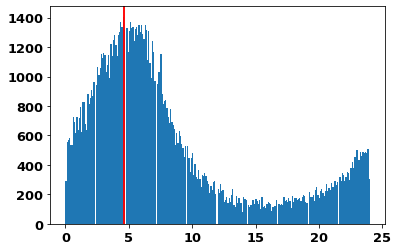

In [229]:
_ = plt.hist(df_for_stats_true_water['phase_season'].round(1), bins = 250)
# plt.xlim([0, 0.3])
plt.axvline(x=mode_apply(df_for_stats_true_water['phase_season'].round(1)), c = 'r')
plt.axvline(x=phase_circmean(df_for_stats_true_water['phase_season']), c = 'r')

In [375]:
# df_for_stats_water

NESM3
3.356148444838609
2.8
0.6430598941239252
0.2828


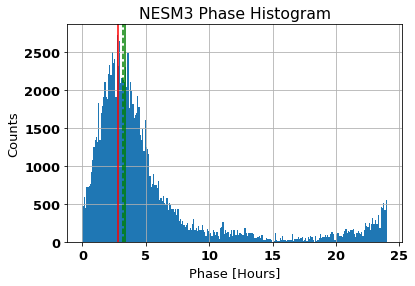

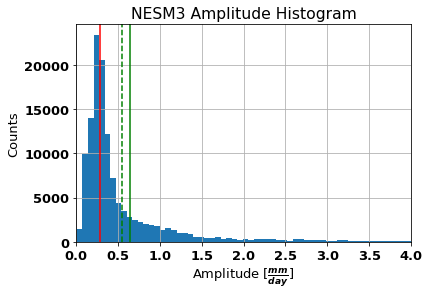

In [537]:
mods = df_for_stats_water['model_name'].unique()
mod = mods[4]
# mod = 'MIROC6'
print(mod)
mod_df_i = df_for_stats_water[df_for_stats_water['model_name'] == mod]



lat_weighted_phase_mean_i = lat_weighted_circ_mean(mod_df_i, 'phase_season')
phase_mode_i = mode_apply(mod_df_i['phase_season'].round(1))

lat_weighted_ampl_mean_i = df_mean_lat_weighted(mod_df_i, 'ampl_season')
ampl_mode_i = mode_apply(mod_df_i['ampl_season'].round(4))

print(lat_weighted_phase_mean_i)
print(phase_mode_i)

print(lat_weighted_ampl_mean_i)
print(ampl_mode_i)

_ = plt.hist(mod_df_i['phase_season'], bins = 250)
plt.title(mod + ' Phase Histogram')
plt.axvline(x= phase_mode_i, c = 'r')
plt.axvline(x=phase_circmean(mod_df_i['phase_season']), c = 'g', linestyle = '--')
plt.axvline(x=lat_weighted_phase_mean_i, c = 'g')
plt.grid()
plt.ylabel('Counts')
plt.xlabel('Phase [Hours]')
plt.savefig(save_fig_dir_update + mod + '_phase_hist.png', dpi = 300)

plt.figure()
_ = plt.hist(mod_df_i['ampl_season'], bins = 250)
# plt.yscale('log')
plt.title(mod + ' Amplitude Histogram')
plt.axvline(x= ampl_mode_i, c = 'r')
plt.axvline(x=phase_circmean(mod_df_i['ampl_season']), c = 'g', linestyle = '--')
plt.axvline(x=lat_weighted_ampl_mean_i, c = 'g')
plt.ylabel('Counts')
plt.xlabel(r'Amplitude [$\frac{mm}{day}$]')
plt.xlim([0, 4])
plt.grid()
plt.savefig(save_fig_dir_update + mod + '_ampl_hist.png', dpi = 300)

In [498]:
phase_circmean_internal(mod_df_i)

3.7499153755433636

In [506]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)

NameError: name 'gpm_std' is not defined

<Figure size 936x576 with 0 Axes>